# Использование машинного обучения для прогнозирования оттока и кластеризации клиентов

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Чтобы бороться с оттоком клиентов, отдел по работе с клиентами сети перевёл в электронный вид множество клиентских анкет. Задача — провести анализ и подготовить план действий по удержанию клиентов:

- спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    1) выделить целевые группы клиентов;
    2) предложить меры по снижению оттока;
    3) определить другие особенности взаимодействия с клиентами.

## Краткий план работы:

- [Описание данных](#1)
- [Исследовательский анализ данных (EDA)](#2)
- [Построение модели бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце](#3)
- [Кластеризация клиентов](#4)
- [Выводы и базовые рекомендации по работе с клиентами](#5)

## Описание данных: <a id='1'></a>

Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).


Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.


In [1]:
# Подгружаем необходимые библиотеки

import pandas as pd
import os 
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import itertools
import warnings
warnings.simplefilter("ignore", ResourceWarning)
warnings.simplefilter("ignore", FutureWarning)
pd.options.display.max_colwidth = 120

In [2]:
# Создаем датафрейм

if os.path.exists(r'C:\Users\abagapov\Downloads\gym_churn.csv'):
    df = pd.read_csv(r'C:\Users\abagapov\Downloads\gym_churn.csv')
else:
    df = pd.read_csv('/datasets/gym_churn.csv')
    
df.name = 'gym_churn'

In [3]:
# Создаем функцию для первичного анализа

def first_view(df):
    '''
    Фунция, дающая общее представление о датасете
    '''
    print('Таблица:', df.name)
    print('*'*50)
    print('Общая информация о датасете:')
    print('*'*50)
    df.info('*'*50) 
    print('*'*50)
    print('Пять случайных строк таблицы:')
    display(df.sample(5, random_state=42)) 
    print('*'*50)
    print('Статистические параметры таблицы:')
    display(df.describe())
    print('*'*50)
    print('Количество пустых значений:')
    display(pd.DataFrame(df.isna().sum()).style.background_gradient('coolwarm')) 
    print('*'*50)
    print('Доля пропусков в столбцах:')
    display(pd.DataFrame(df.isna().mean()).style.background_gradient('coolwarm'))
    print('*'*50)
    print('Количество полных дубликатов:')
    print(df.duplicated().sum()) 
    print('*'*50)

## Исследовательский анализ данных (EDA) <a id='2'></a>

In [4]:
first_view(df)

Таблица: gym_churn
**************************************************
Общая информация о датасете:
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract             

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
555,1,1,0,0,1,6,1,37,205.631751,5.0,2,1.400690,1.614663,0
3491,0,0,0,0,1,6,0,27,137.370917,6.0,24,0.918920,1.093414,0
527,1,1,0,0,1,1,1,25,41.607768,1.0,1,2.893104,2.813602,0
3925,1,0,0,0,1,1,0,31,9.593524,1.0,14,2.131718,2.147013,0
2989,1,1,0,0,0,1,0,30,275.271537,1.0,4,1.653789,1.738444,0


**************************************************
Статистические параметры таблицы:


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**************************************************
Количество пустых значений:


,0
gender,0
Near_Location,0
Partner,0
Promo_friends,0
Phone,0
Contract_period,0
Group_visits,0
Age,0
Avg_additional_charges_total,0
Month_to_end_contract,0


**************************************************
Доля пропусков в столбцах:


,0
gender,0.000000
Near_Location,0.000000
Partner,0.000000
Promo_friends,0.000000
Phone,0.000000
Contract_period,0.000000
Group_visits,0.000000
Age,0.000000
Avg_additional_charges_total,0.000000
Month_to_end_contract,0.000000


**************************************************
Количество полных дубликатов:
0
**************************************************


В датафрейме всего 4000 строк, пропуски и полные дубликаты отсутствуют.

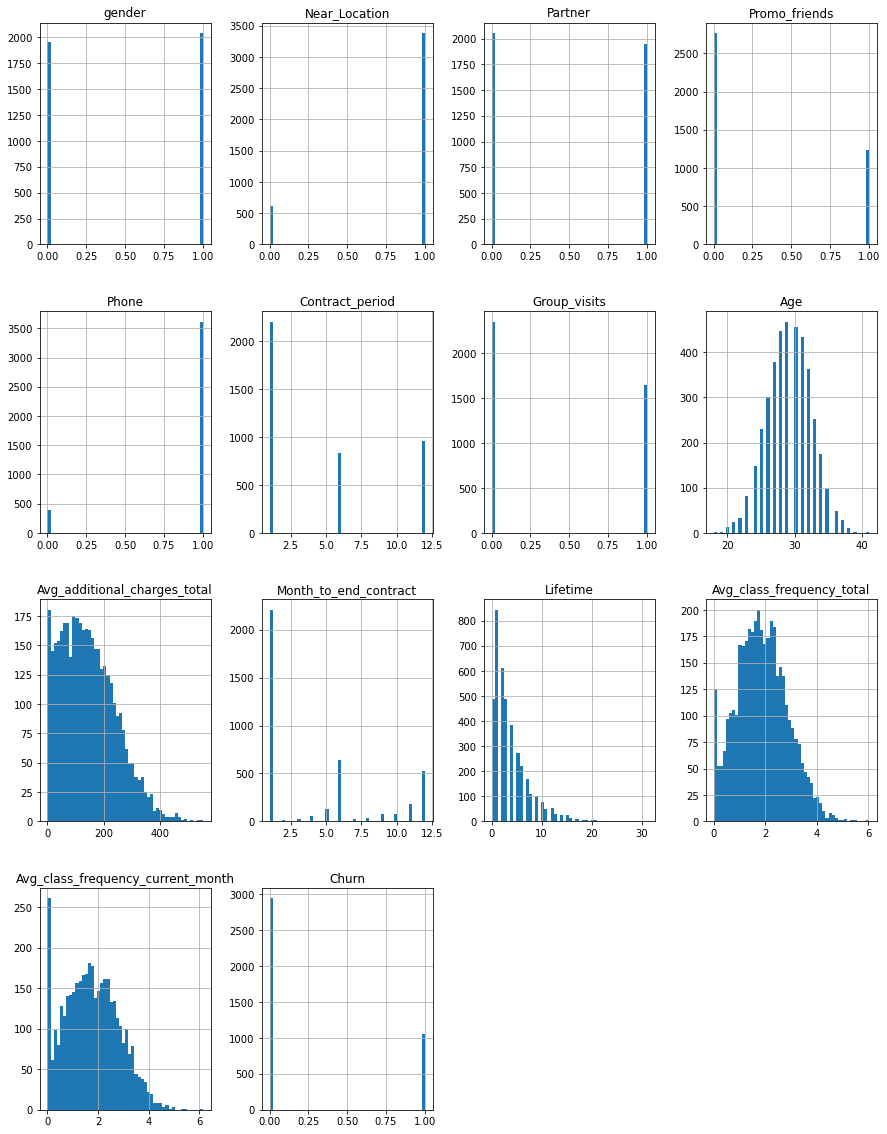

In [5]:
# Построим гистограмму признаков

df.hist(figsize=(15, 20), bins=50);

Гистограммы, в большинестве своем, кажутся вполне ожидаемыми: доля мужчин и женщин примерно ровна, возраст распределен нормально, выброс около нуля в столбце Avg_additional_charges_total объясняется нежеланием многих посетителей пользоваться дополнительными услугами. Выбросы же около нуля в столбцах Avg_class_frequency_current_month и Avg_class_frequency_total говорят о том, что некоторые люди перестают ходить в центры (или еще не начинали). 

In [6]:
# Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался


df.groupby('Churn').agg('mean').T

Churn,0,1
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


Можно сказать, что в среднем для отточных клиентов основные показатели меньше: они моложе по возрасту, меньше посещаюь зал, меньше приносят деньги через дополнительные услуги и у них раньше заканчивается абонемент.

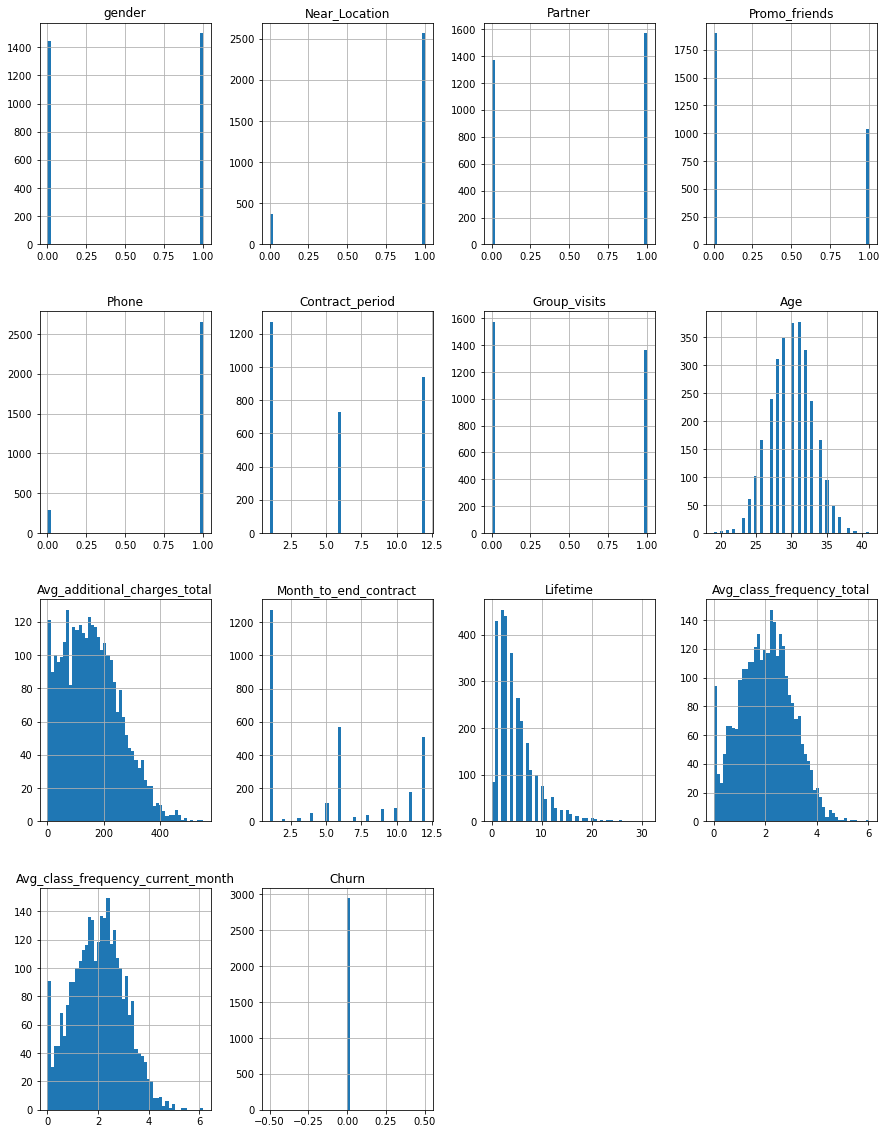

In [7]:
df.query('Churn == 0').hist(figsize=(15, 20), bins=50);

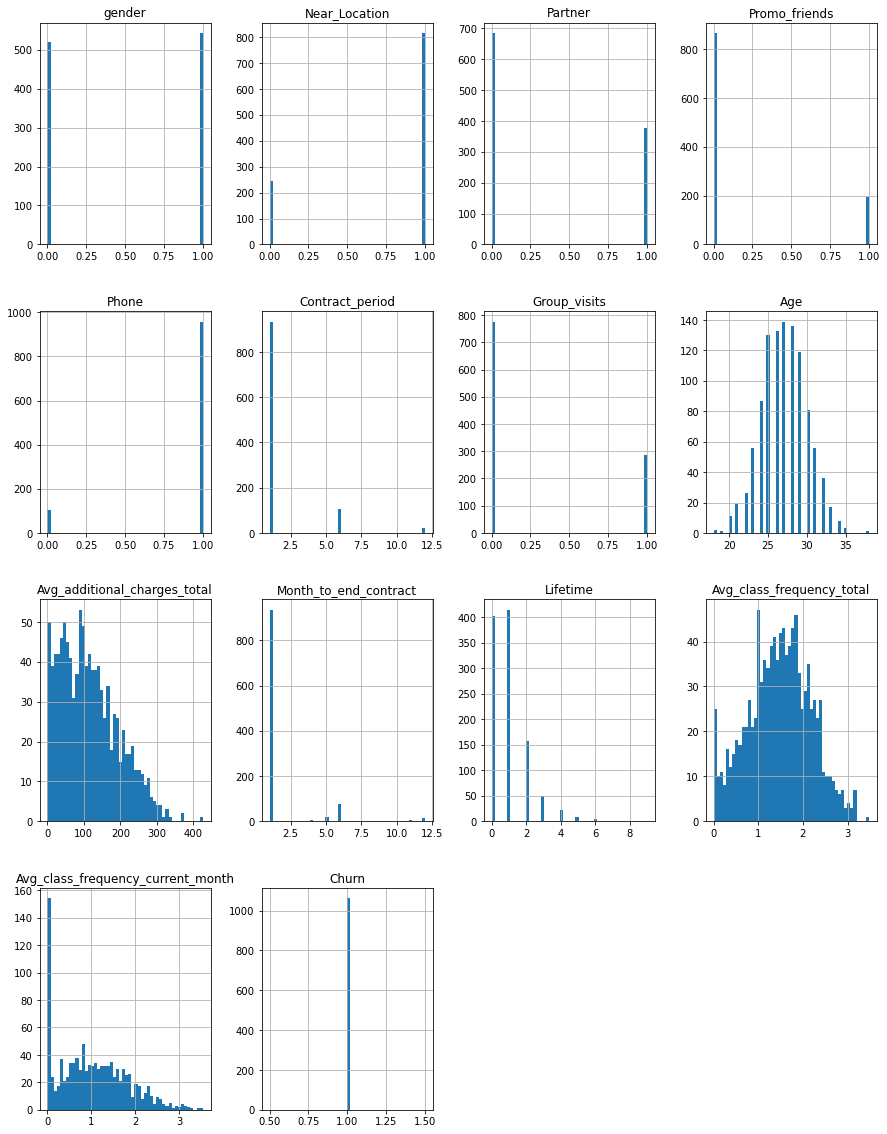

In [8]:
df.query('Churn == 1').hist(figsize=(15, 20), bins=50);

Сравнивая гистограммы для оставшихся и ушедших, можно сказать, что: 1) в срезе с ушедшими количество посетителей, являющихся сотрудниками компании-партнера, значительно больше, чем не являющихся. В срезе же с оставшимися не являющихся больше, чем сотрудников партнеров; 2)среди ушедших подавляющее большинство брали абонемент на месяц; 3) также ушедшие, в большинстве своем, не посещали групповые занятия; 4) гистограмма по посещениям в предыдущий месяц у ушедших имеет большой пик около нуля, т.е. множество ушедших перестали посещать раньше, чем в предыдущий месяце; 4) из ушедших большая доля, чем из оставшихся, пришла по акции "Приведи друга". 

In [9]:
df.corr()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
Near_Location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
Partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
Promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
Phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
Contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
Group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
Age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
Avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
Month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


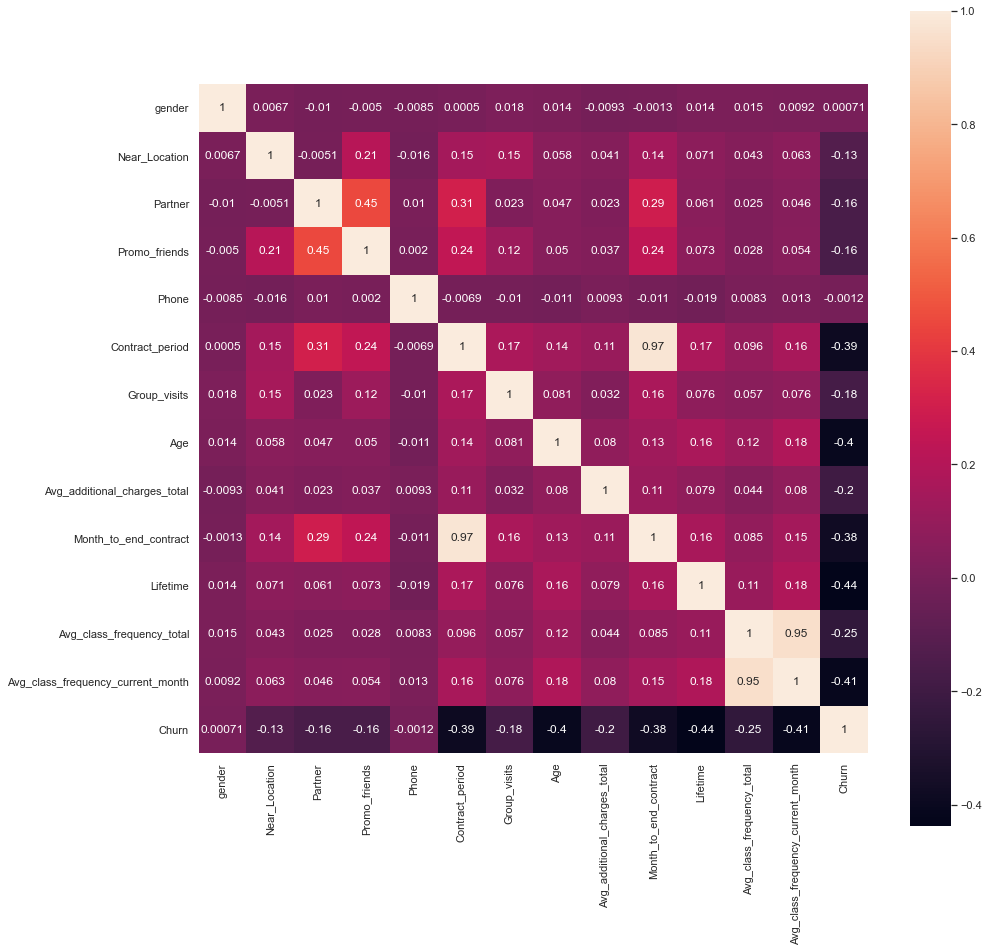

In [10]:
sns.set(rc={'figure.figsize':(15,15)})
fig, ax = plt.subplots()
sns.heatmap(df.corr(), annot=True, square=True)
plt.show()

Очень сильно коррелируют Contract_period и Month_to_end_contract (0.97), Avg_class_frequency_total и Avg_class_frequency_current_month (0.95). Остальные корреляции если и прусутствуют, то являются средними или слабыми. С интересующими нас значениеми Churn слабо и отрицательно коррелируют столбцы Contact_period, Age, Month_to_end_conract, Lifetime, Avg_class_frequency_current_month.

Был загружен датафрейм в 4000 строк. Пропуски, выбросы, явные дубликаты отсутствуют. Строки и столбцы не удалялись, типы данных не менялиясь. Данные качественно и количественно подходят под задачи машинного обучения.

Средние значения признаков в двух группах ("ушёл в отток" и "не ушёл") говорят о том, что ушедшие являются меняя увлеченными пользователями: они меньше ходят в зал, меньше посещают групповые занятия, меньше тратят деньги. Также среди них меньше сотрудников компани-партнеров и пришедших по акиции "приведи друга".

По степени корреляции с целевой переменной можно выделить три группы: 1) слабо-отрицательно коррелируют 5 признаков; 2) очень слабо-отрицательно - 5 признаков; 3) не корреклирует 2 признака.

Особое внимание стоит обратить на признаки Contact_period и Month_to_end_conract. Они очень сильно коррелируют между собой, и каждый из них слабо коррелирует с целевой переменной, что говорит о мультиколлинеарность и связанных с ней возможных проблемах с обучением моделей.

## Модель прогнозирования оттока клиентов <a id='3'></a>

In [11]:
# Создаем датафреймы с признаками и целевой переменной

X = df.drop(columns=['Churn'], axis=1)
y = df['Churn']

In [12]:
# Разбиваем датафреймы на обучающие и тестовые выборки в соотношении 80/20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
# Посмотрим на размеры выборок

for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(3200, 13)
(800, 13)
(3200,)
(800,)


Размеры выборок соответствуют ожидаемым.

In [14]:
# Создаем список моделей: Логистическую регрессию и Случайный лес

models = [
    LogisticRegression(solver='liblinear'),
    DecisionTreeClassifier(random_state=0)
]

In [15]:
# Создаем функцию, обучающую модели и возвращающая метрики

def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
            'accuracy:{:.2f} precision:{:.2f} recall:{:.2f} '.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred)
        )
    )

In [16]:
# Создаем и обучаем модели

for i in models:
    print(i)
    make_prediction(i, X_train, y_train, X_test, y_test)

LogisticRegression(solver='liblinear')
accuracy:0.93 precision:0.86 recall:0.83 
DecisionTreeClassifier(random_state=0)
accuracy:0.90 precision:0.79 recall:0.80 


Модель логистической регрессии по всем метрикам показала лучшие результаты, поэтому предлагается именно ее использовать для прогнозирования оттока клиентов. Модель показала высокий accuracy (долю правильных ответов), высокий precision (долю правильных ответов среди целевого класса) и recall (долю верно угаданных Positive к их общему числу).

## Кластеризация клиентов <a id='4'></a>

In [17]:
# Стандартизируем признаки

sc = StandardScaler()

X_sc = sc.fit_transform(X)

In [18]:
# Создадим таблицу связок между признаками

linked = linkage(X_sc, method = 'ward') 

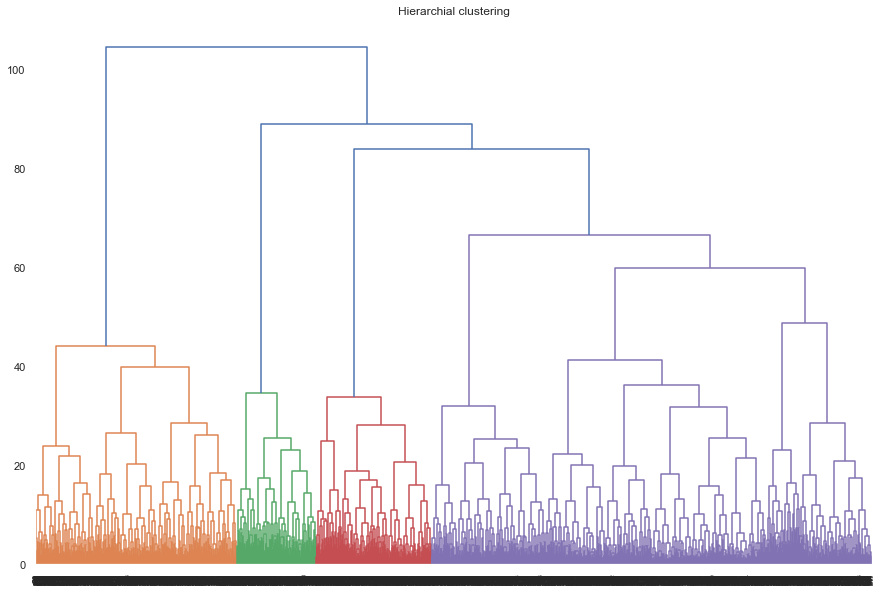

In [19]:
# И визуализируем ее как дендрограмму

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering')
plt.show() 

Алгоритм выделил четыре кластер, но можно увеличить разделение до 5, но вряд ли больше из-за возможного перекрытия.

In [20]:
# Создадим модель k_means с числом кластеров 5

km = KMeans(n_clusters=5, random_state=0)

In [21]:
# Спрогнозируем кластеры

labels = km.fit_predict(X_sc)

In [22]:
# Посчитаем метрику silhouette_score для модели

print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.14


Значение метрики небольшое, около 0, что говорит о перекрытии кластеров.

In [23]:
# Сохраним метки в датафрейм

df['cluster_client'] = labels

In [24]:
# выведем статистику по средним значениям наших признаков по кластеру

df.drop('Churn', axis=1).groupby('cluster_client').agg('mean').T

cluster_client,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
Near_Location,0.959406,0.862338,0.000000,1.000000,0.976134
Partner,0.783168,0.470130,0.463366,0.350238,0.356802
Promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
Phone,1.000000,0.000000,1.000000,1.000000,0.998807
Contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
Group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
Age,29.982178,29.301299,28.477228,28.167987,30.125298
Avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
Month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


Самыми лояльными кажутся кластеры 0 и 4: у них самые высокие показатели посещения залов, лайфтайма, прибыли от дополнительных услуг. Подавляющее большинство посетителей данных кластеров живут в районе, где находится фитнес-центр. В кластере 1 высокие показатели пришедших по акции "приведи друга" и сотрудников компаний-партнеров, также у них самые длинные абонементы. Кластер же 4 показывает лучшие показатели по посещению зала и выручке от доп. сервисов. Можно сказать, что данные кластеры объединяют постоянных клиентов.

Самым неактивным кажется кластер под номером 3: он показал худшие частоту посещения центров за все время и за прошлый месяц, худшую выручку по дополнительным сервисам. Кажется, все клинты данного кластеры живут в районе, где находится фитнес-центр. Участников акции "приведи друга" и сотрудников компаний-партнеров в данным кластере примерно столько же, сколько в образцово-показательном 4-м, значит, проблема в другом. У данного кластера также наименьший лайфтайм, т.е. это самые новые клиенты, у которых, к тому же, быстрее всего закончится абонемент, а поэтому нужно создать условия для их ужержания.

Также признаки слабой активности показывает кластер 2: он на втором месте с конца по показателям посещаемости зала, лайфтайму (поэтому их тоже можно назвать новыи клиентами), сроку окончания абонемента и выручки от доп. услуг. Посетители из данного кластера хуже всего ходят на групповые занятия. Практически никто из них не пришел по акции "приведи друга", но половина из них являются сотрудниками компаний-партнеров. Также ни один из данного кластера не живет в районе, в котором находится фитнес-центр.

Кластер 1 показывает средние показатели, а посетители из него очень не хотят делиться личным телефоном. Кроме того, по показателю времени до окончания действия абонемента данный кластер уступает только 0-му.

In [25]:
# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам

def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

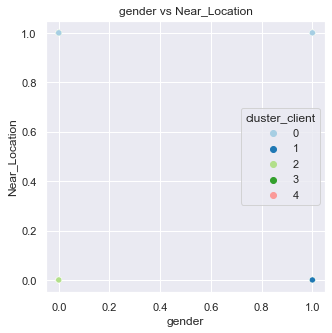

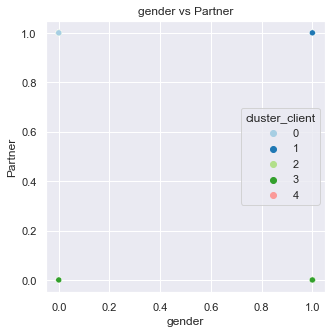

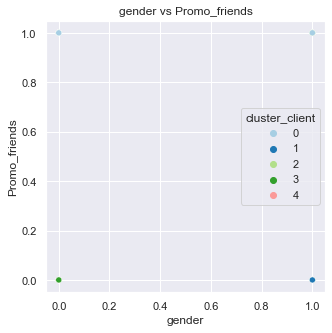

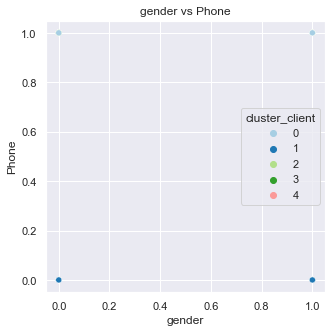

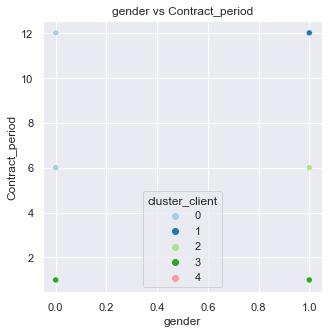

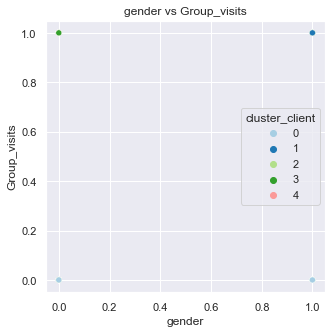

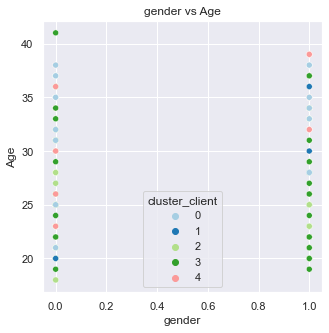

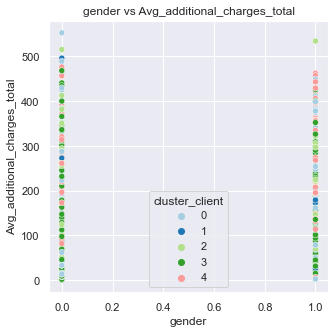

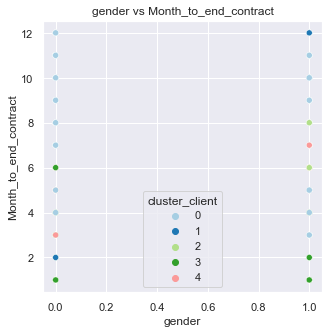

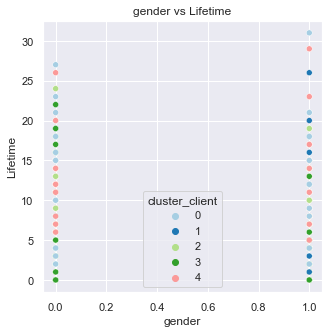

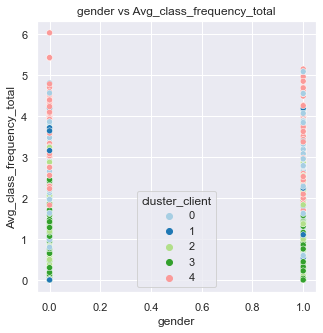

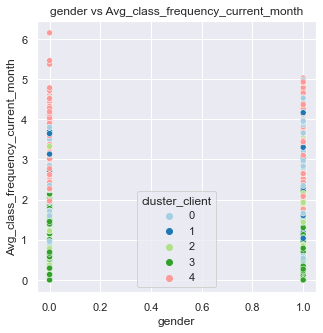

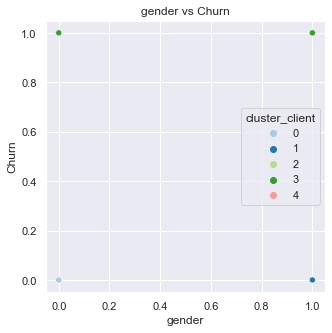

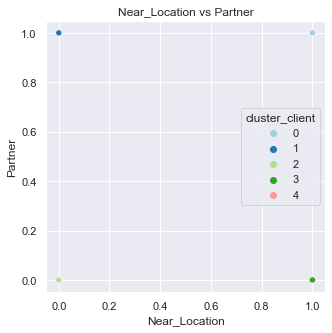

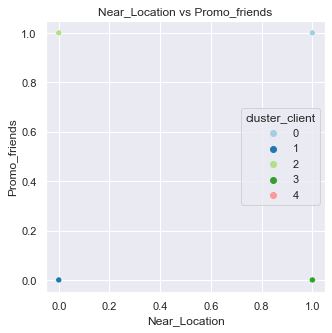

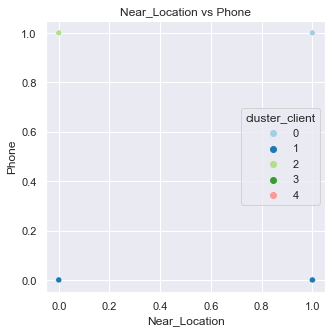

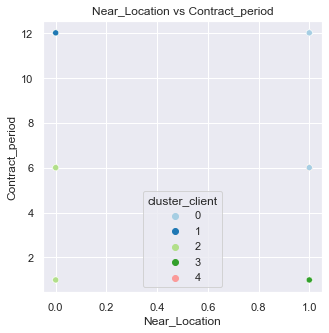

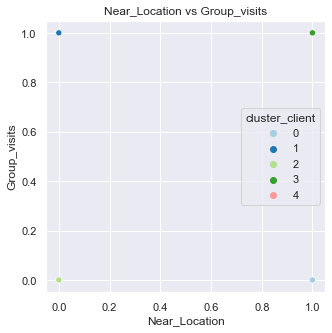

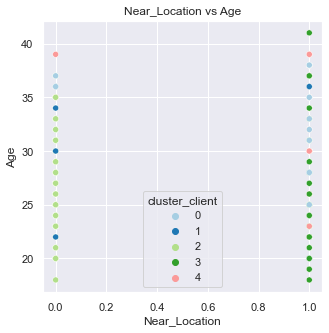

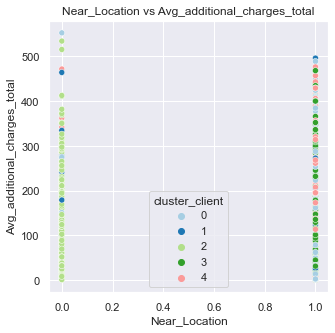

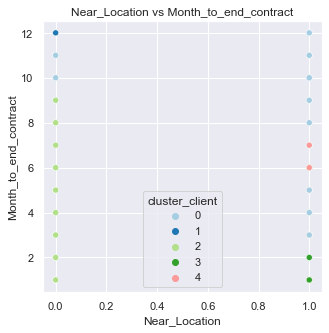

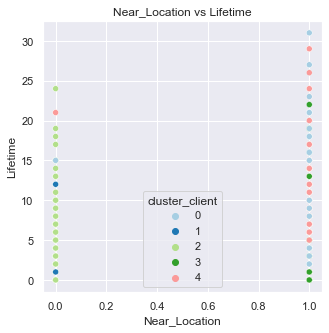

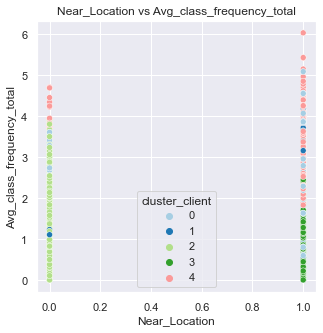

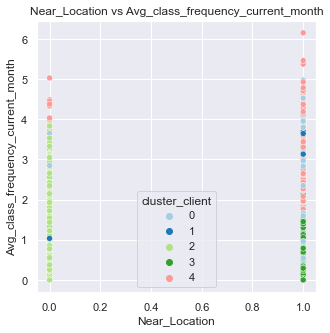

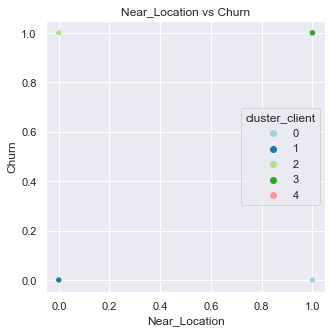

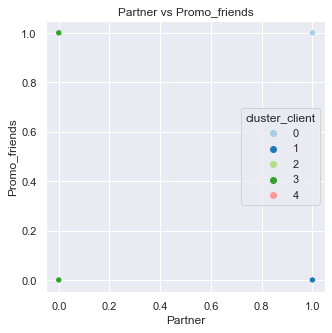

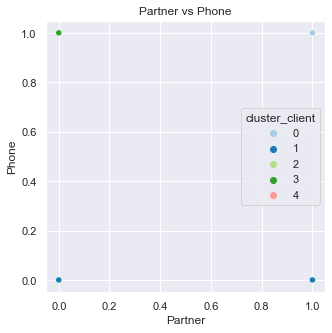

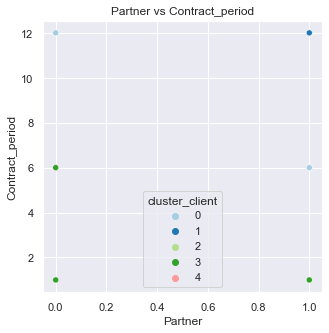

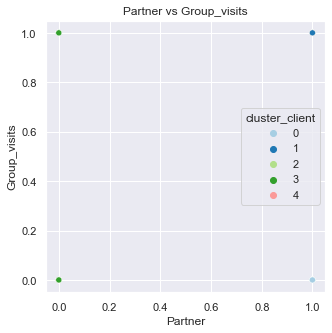

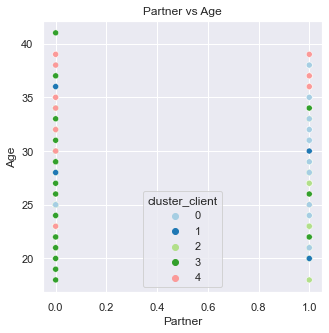

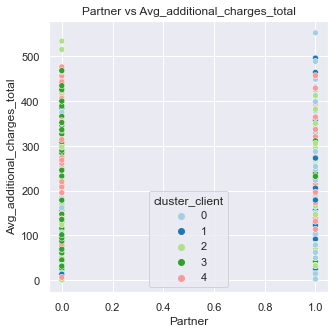

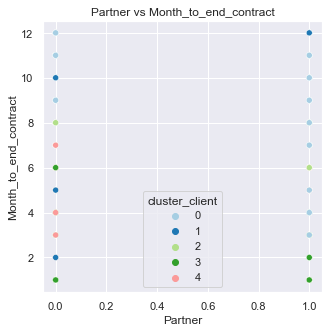

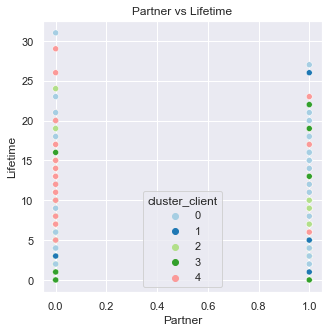

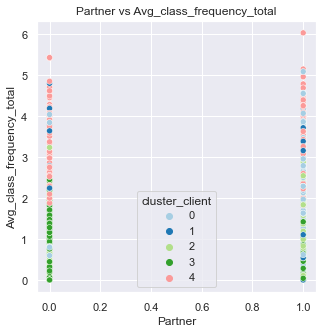

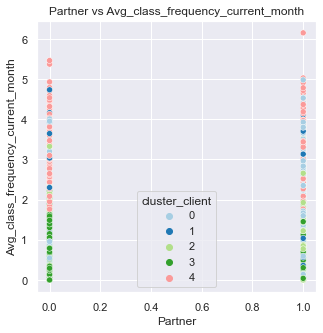

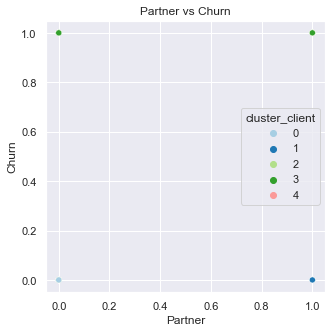

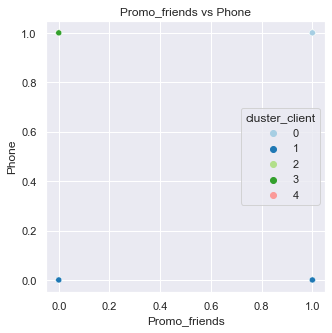

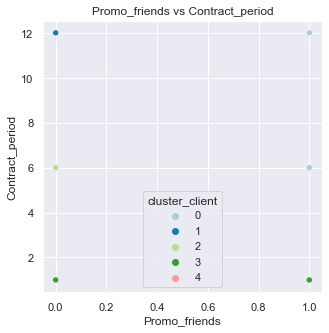

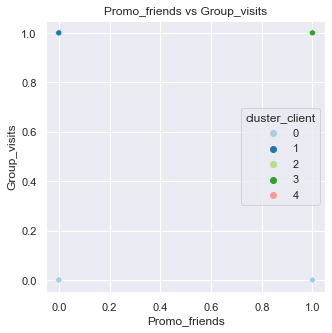

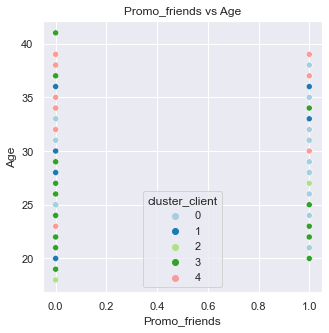

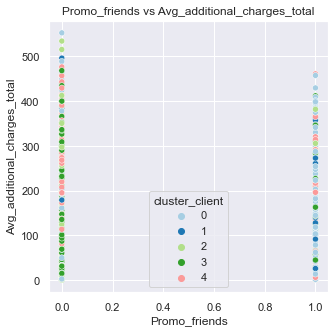

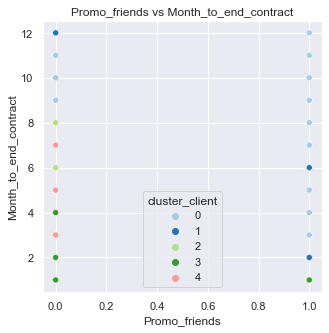

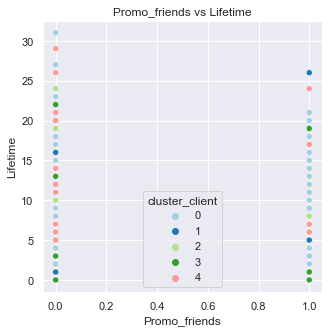

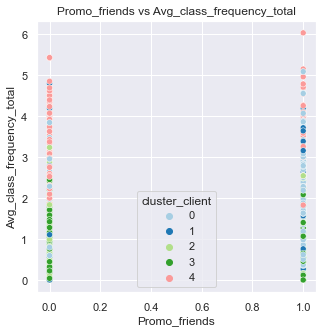

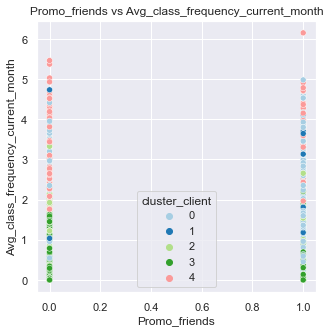

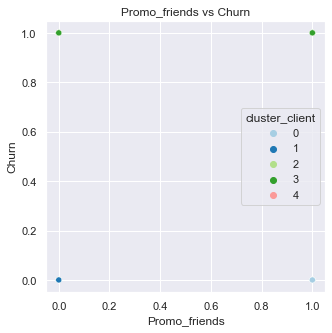

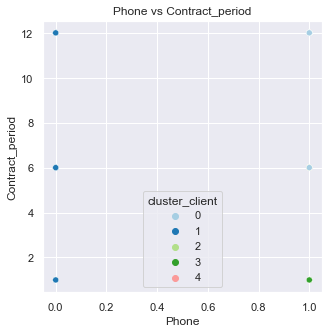

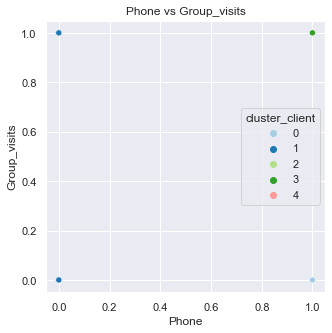

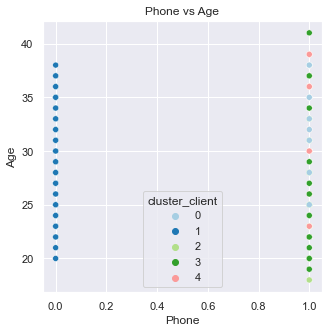

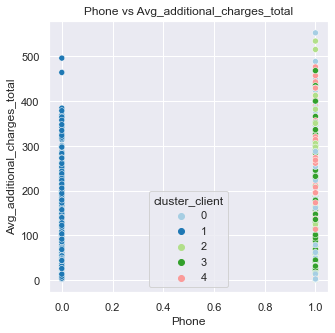

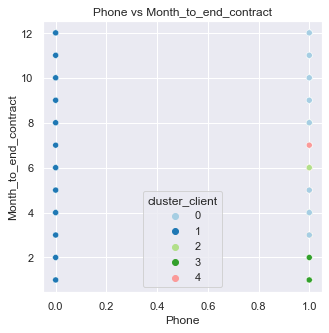

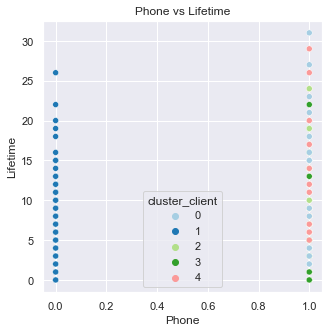

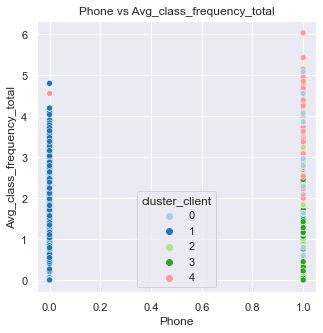

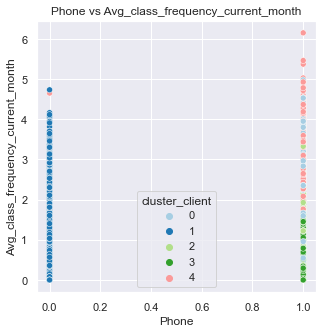

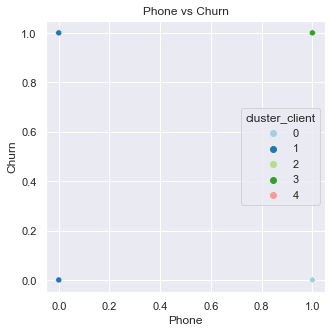

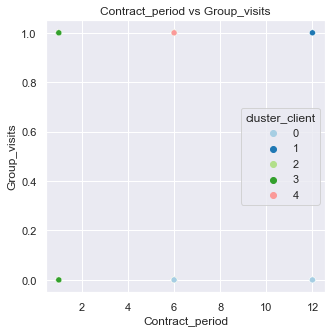

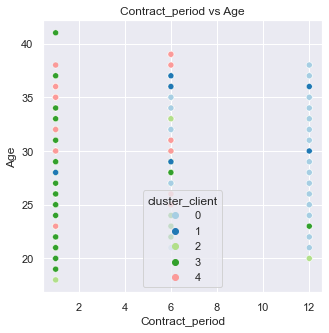

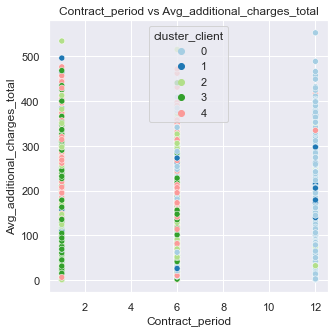

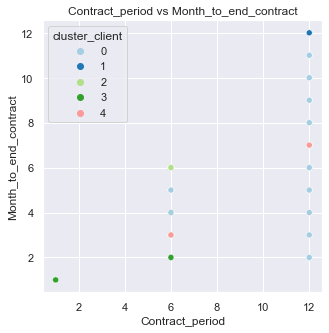

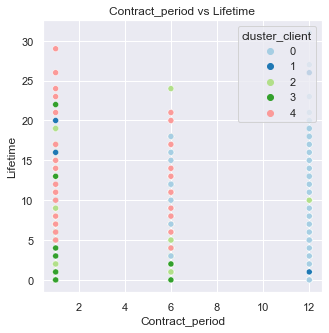

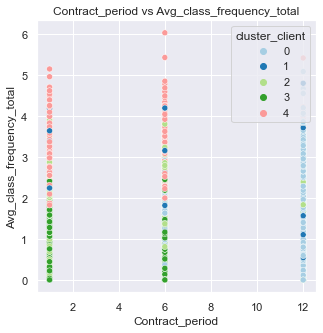

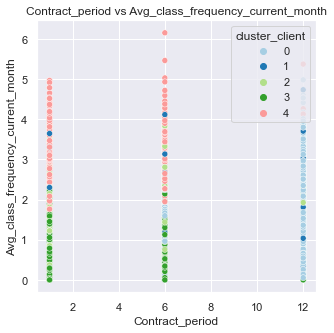

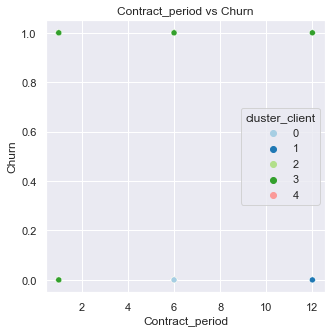

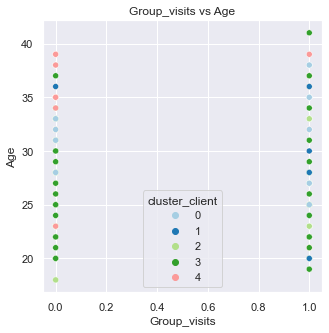

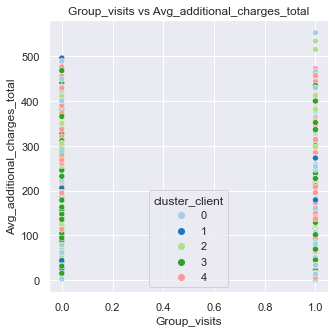

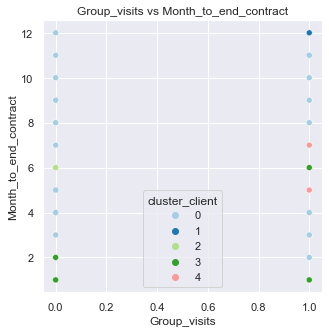

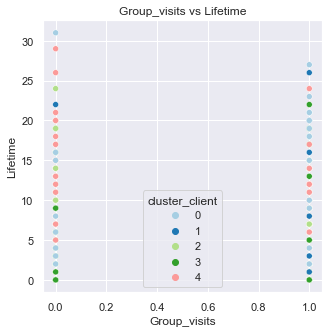

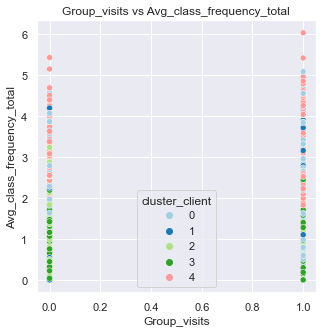

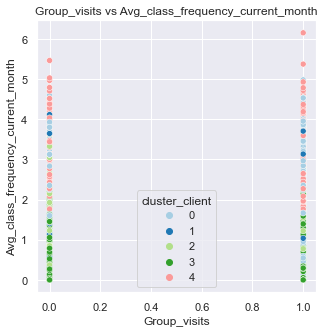

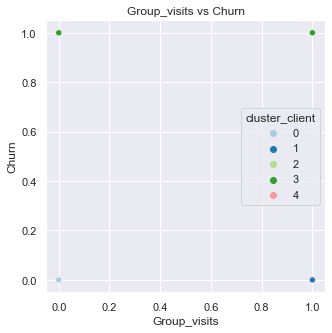

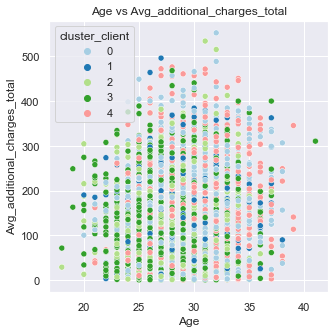

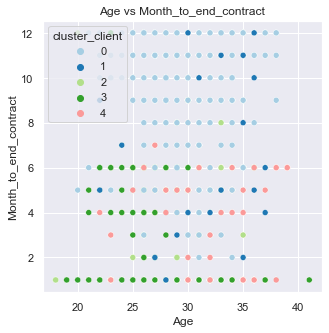

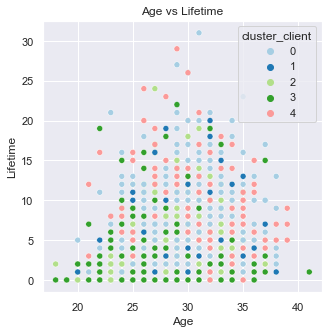

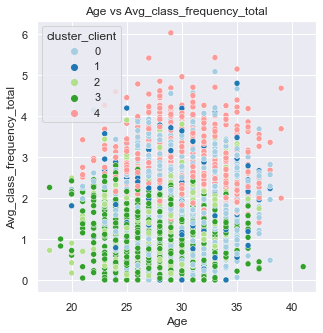

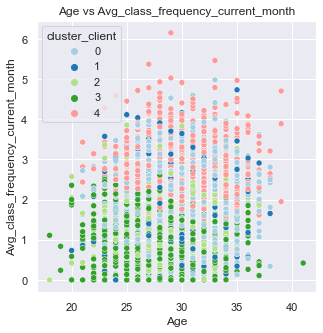

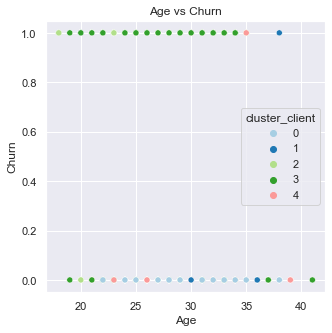

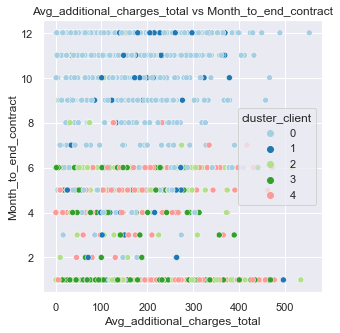

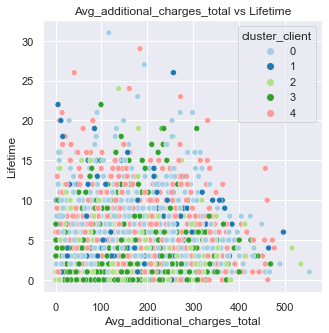

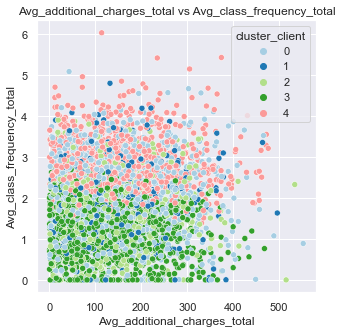

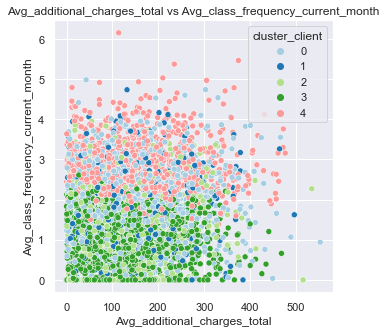

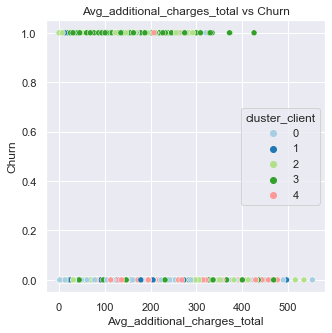

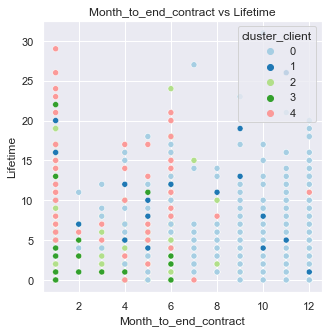

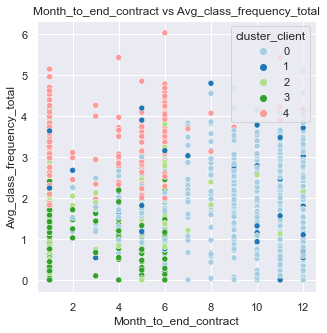

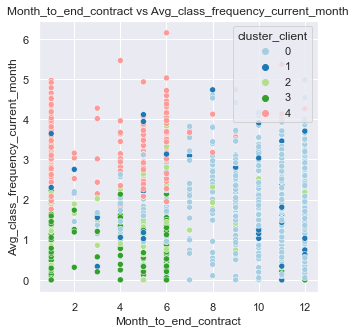

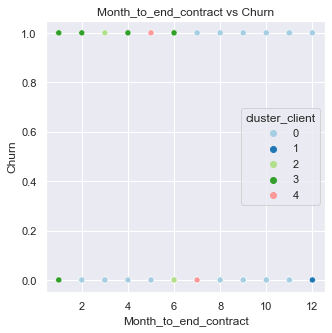

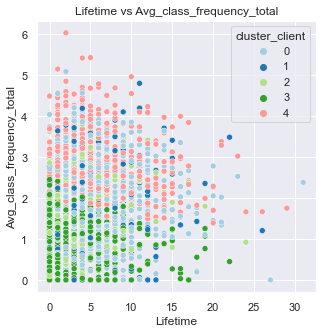

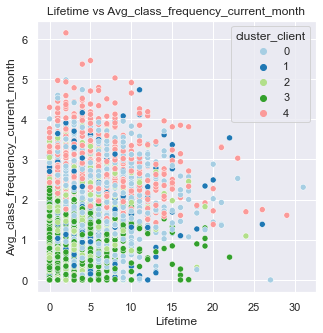

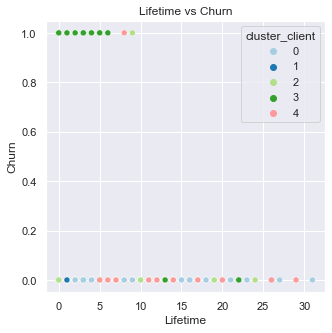

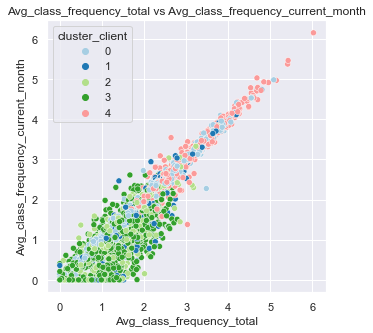

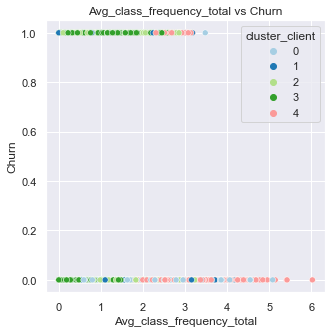

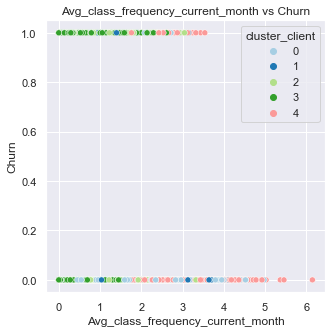

In [26]:
col_pairs = list(itertools.combinations(df.drop('cluster_client', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(df, pair[0], pair[1], 'cluster_client')

Менее всего структурирован кластер 1: его показатели разбросаны по всему графику, поэтому в целом о нем нельзя сказать ничего определенного.

Наиболее интересующие нас кластеры 2 и 3 заметно выделяются и часто неотличимы друг от друга. Большая часть из них использует месячные абонемент, сильно реже - полугодовой. При посещение зала почти не превышает 1-2 раза в неделю.

Также для всех кластеров заметна тенденция - чем больше лайфтам, тем меньше среднее количество посещение центра в неделю. При этом для "хороших" кластеров на высоком лайфтайме среднее количество посещений составляет 1-2 в неделю, для "плохих" - меньше одного. Несмотря на это, "долгожители" из "плохих" кластеров не относятся в уходящим клиентам.

In [27]:
# Для каждого кластера посчитаем долю оттока

df.groupby('cluster_client').agg({'Churn':'mean'})

,Churn
cluster_client,
0,0.027723
1,0.267532
2,0.443564
3,0.514263
4,0.068019


0 и 4 кластер показали результаты с оттоком менее 1%, что радует.

Из 2-го и 3-го кластера же уходит примерно половина посетителей. Так как мы можем примерно определить характеристики уходящих по данным кластерам, работать предлагается именно с ними.

Также 26% посетителей теряет аморфный кластер 1. 

## Вывод <a id='5'></a>

Исходным материалом для анализа являлись оцифрованные данные пользователей сети фитнес-центров. Был проведен исследовательский анализ данных, который выявил некоторые различия между группами ушедших и оставшихся пользователей, а также корреляции между некоторыми признаками.

Для прогнозирования оттока клиентов были созданы и обучены две модели: логистическая регрессия и случайный лес. Лучшие показатели по метрикам качества показала логистическая регрессия, поэтому предлагается  использовать именно ее.

При решении задачи кластеризации была построена дендерограмма, которая предложила выбрать 4 кластера, но в модели кластеризации было решено использовать 5. Модель была построена на алгоритме K-mean и разбила пользователей на кластеры с перекрытием, т.е. с нечеткими границами между ними. 

На основании анализа кластеров были выявлены два из них, которые показывают большой отток. Данные кластеры имеют явные характеристики, поэтому по ним можно сегментизировать пользователей для работы по их удержанию. 

Особое внимание нужно обратить на клиентов, начавших посещать центры менее трех месяцев назад - именно данная группа показывает самый высокий процент ушедших. 

Если сравнивать кластер 3 (плохой) и кластер 4 (хороший), можно заметить, что они различаются только тем, что посетители из кластера в среднем дольше посещают центры и чаще ходят на занятия. Так как в кластере 3 много ушедших, их среднее посещение зала может искажаеться в сторону меньшего значения. Отсюда, нужно сделать упор на увеличение лайфтайма продолжающих ходить новичков. Большая часть из них покупает короткие абонементы - на месяц, сильно реже - на полгода, но их их абонементы кончаются уже в ближайшие месяцы. Кажется, посетителям данного кластера нужно просто привыкнуть к центру. Возможно, следует предложить им скидку на следующий длинный абонемент (от полугода до года)?

Другой плохой сегмент 2 характеризуется ярче всего тем, что посетителя живут не в том районе, где находится фитнес-центр. Вероятно, с этим связано то, что почти никто из них не пришел по акции "приведи друга", но многие из них сотрудники компаний-партнеров. Как правило, абонементы у данного кластера чуть длиннее, чем у 3-го, но также скоро заканчиваются. Для клиентов из других районов можно создать более "гибкие" условия: предложить скидки на тарифы с безлимитным посещением по времени в день или в любой день недели, предложить скидки на персональные тренировки с инструктором и пр.

Кроме того, так как у подавляющего большинства клиентов указан номер телефона, а их обонементы часто подходят к концу, можно создать функцию уведомления по СМС об окончании срока обонемента и о возможных скидках.

Плохой клсастер 1 выглядит на фоне других более аморфным и не содержит устойчивых характеристик, поэтому с клиентов из данного кластера нужно изучить глубже и работать с ними более индивидуально, предлагая, к примеру, скидки на день рождения.

Также долгожителей из плохого кластера 1 и представителей хороших кластеров 0 и 4 можно дополнительно стимулировать скидками на дополнительные услуги центра.